In [1]:
import os
import numpy as np
import h5py
from scipy import stats
import scipy.io
import mne
from random import shuffle
import random

mne.set_log_level('error')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold




from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors


import torch
import torch.nn as nn
import torch.optim as optim

import optuna


from utils.load import Load
from config.default import cfg

%load_ext autoreload
%autoreload 2


##### Load EEG data in MNE format to access electrode position

In [2]:
subject_id = 0


In [3]:
loader = Load(cfg)
demo = loader.load_subject(subject_id = subject_id)[0]

#### Training

In [4]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
print(device)

cuda


In [5]:
# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's built-in random number generator
random.seed(42)

# Set seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
# Load the dictionary from the HDF5 file
target_dir = 'features'
tag = '0_25powers'

file_path = os.path.join(target_dir, tag+'_'+cfg['subjects'][subject_id] + '.h5')


data = {}
with h5py.File(file_path, 'r') as h5file:
    for key in h5file.keys():
        data[key] = np.array(h5file[key])

# Print the loaded data dictionary
for key, value in data.items():
    #data[key] = np.reshape(value, (value.shape[0], -1))
    print(key, data[key].shape)

index (50, 158, 30, 2)
little (50, 158, 30, 2)
middle (50, 158, 30, 2)
ring (50, 158, 30, 2)
thumb (50, 158, 30, 2)


In [8]:
class SingleLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation):
        super(SingleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        x = x.view(x.size(0), -1)
 
        x = self.fc1(x)
      
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [34]:
def train(X_train, y_train, X_test, y_test, model, criterion, optimizer, num_epochs=100):
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)


    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        y_pred = model(X_test)
        y_pred = torch.argmax(y_pred, dim=1)

    acc = accuracy_score(y_test.cpu(), y_pred.cpu())
    return acc


finger1 = 'thumb'
finger2 = 'ring'
learning_rate = 0.0028774322222191256
num_epochs= 1860
hidden_size =47
activation =nn.ReLU()
optimizer = optim.SGD


X = np.concatenate((data[finger1], data[finger2]), axis=0)
y = np.concatenate((np.ones(data[finger1].shape[0]), np.zeros(data[finger2].shape[0])), axis=0)

   
# Normalize the data
orig_shape = X.shape
X = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(orig_shape)



model = SingleLayerMLP(X.shape[1]*X.shape[2]*X.shape[3], hidden_size, 2, activation)
model.to(device)

########################################
###########  WARNING      ##############
########################################
# shuffle = False -> acc ~ 0.8
# shuffle = True -> acc ~ 0.5
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer(model.parameters(), lr=learning_rate)

train(train_X, train_y, test_X, test_y, model, criterion, optimizer, num_epochs=num_epochs)



0.85

In [44]:
def draw_saliancy_scalp_plot(subject_id, role_values, finger):
    montage = np.array(list(demo.get_montage().get_positions()['ch_pos'].values()))

    ROI_montage = []
    not_ROI_montage =[]
    for i in range(256):
        ch_name = 'c' + str(i+1)
        if ch_name in cfg['not_ROI_channels']:
            not_ROI_montage.append(montage[i])
        else:
            ROI_montage.append(montage[i])
    ROI_montage = np.array(ROI_montage)
    not_ROI_montage = np.array(not_ROI_montage)



   
    # Normalize role_values for color mapping
    normalized_role_values = (role_values - role_values.min()) / (role_values.max() - role_values.min())
  
    # Create a custom colormap to map role values to colors
    colors = [(1, 1, 0), (0, 0, 1)]  # Red, Yellow, Blue
    custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=256)


    # Create the 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    not_ROIscatter = ax.scatter(not_ROI_montage[:, 0], not_ROI_montage[:, 1], not_ROI_montage[:, 2], c='black', s=50, edgecolor='k')


    scatter = ax.scatter(ROI_montage[:, 0], ROI_montage[:, 1], ROI_montage[:, 2], c=normalized_role_values, cmap=custom_colormap, s=50, edgecolor='k')

    # Set the viewing angle
    elevation = 50  # degrees
    azimuth = 180  # degrees
    ax.view_init(elev=elevation, azim=azimuth)

    # Hide coordinate system
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    # ax.xaxis.line.set_lw(0.)
    # ax.yaxis.line.set_lw(0.)
    # ax.zaxis.line.set_lw(0.)

    # Add a colorbar to show the mapping of role values to colors
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label("Mean Gradient Factor")

    # Set the title
    ax.set_title(f"3D Scalp Saliency Plot for {finger} finger")
    plt.savefig(f'saliency_maps/{finger}.png')
    plt.show()


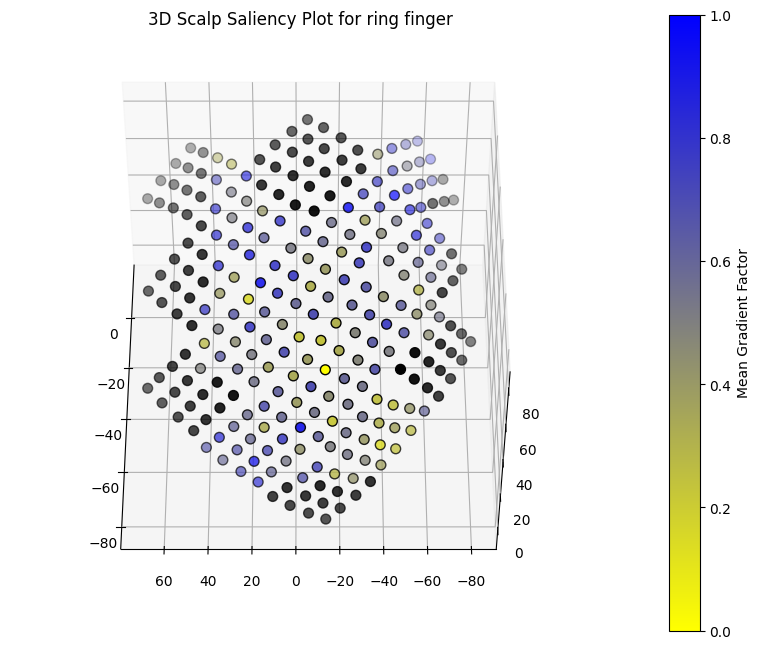

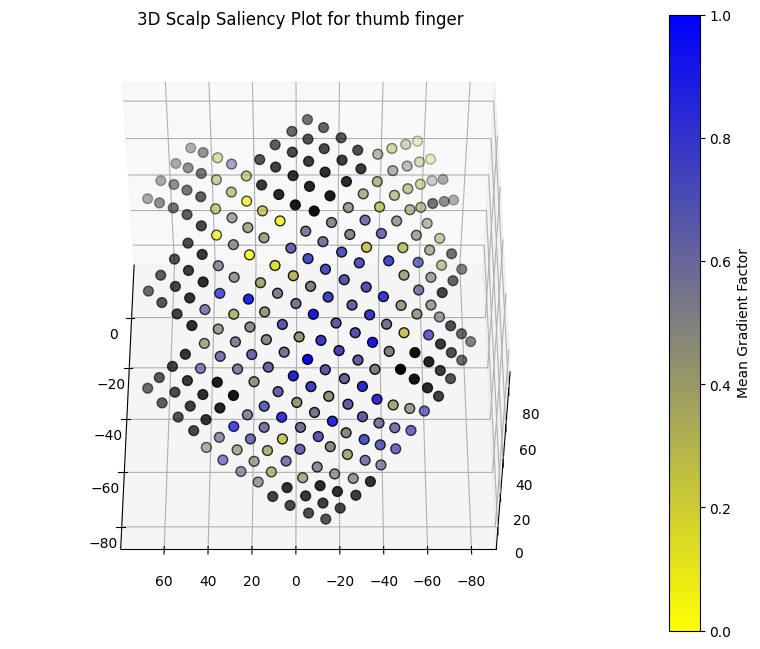

: 

In [45]:
model.eval()
# Print the loaded data dictionary
for key, features in data.items(): # BOTH Train and Test
    if key in ['thumb', 'ring']:
       
        channel_result = np.empty((features.shape[0], features.shape[1]))
        time_result = np.empty((features.shape[0], features.shape[2]))
        for i, f in enumerate(features):

            X = torch.from_numpy(f).float().to(device)

            X = X.unsqueeze(0)

            X.requires_grad_(True)

        
            outputs = model(X)
            #max_scores = max_scores.abs()
            max_scores = outputs.max(dim=1)[0]
        
            max_scores.backward(retain_graph=True)

            saliency = X.grad
           
            saliency = saliency.squeeze(0)              # REMOVE BATCH DIMENSION
            
            saliency = torch.max(saliency, dim=-1)[0]   # MAX OVER FREQUNCY BANDS

          
           

            channel_saliency = torch.mean(saliency, dim=1)      # MEAN OVER TIME
            channel_saliency = channel_saliency.cpu().detach().numpy()  # CONVERT TO NUMPY ARRAY
            channel_result[i] = channel_saliency

        

        # time_average = np.mean(time_result, axis=0)
        # plt.plot(time_average)

        ################### Saliency Sensor Plot ###################
        channel_average = np.mean(channel_result, axis=0)
        saliency_scalp_plot = draw_saliancy_scalp_plot(subject_id,  channel_average, key)
        

